# Replicating Audio Texture Synthesis (by Dimitry Ulyanov)
- Original Source: [Ulyanov's Github](https://github.com/DmitryUlyanov/neural-style-audio-torch)
- Article: [Ulyanov's Blog](https://dmitryulyanov.github.io/audio-texture-synthesis-and-style-transfer/)

In [1]:
import utils
import librosa
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
tfile = Path("../../fma/000/000002.mp3")

In [3]:
wave, sr = librosa.load(tfile)

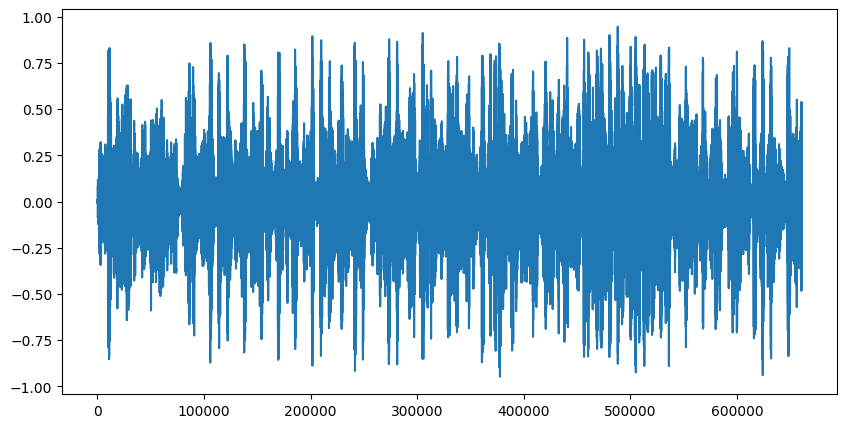

In [4]:
fig = plt.figure(figsize=(10, 5))
plt.plot(wave)
plt.show()

In [5]:
spectrum, phase = utils.stft_wave_to_spectrum(wave)

In [6]:
spectrum.shape

(257, 5164)

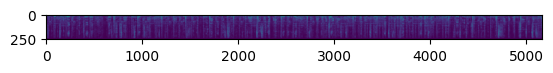

In [7]:
plt.imshow(spectrum)
plt.show()

In [8]:
reconstructed_wave = utils.stft_spectrum_to_wave(spectrum)

In [9]:
len(reconstructed_wave), len(wave)

(660864, 660984)

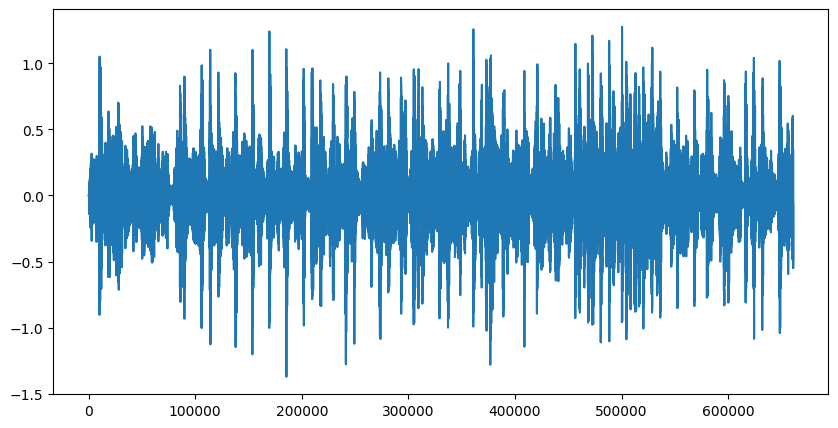

In [10]:
fig = plt.figure(figsize=(10, 5))
plt.plot(reconstructed_wave)
plt.show()

## Training

In [11]:
import model
import torch
from torch.autograd import Variable

import time

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
content_file = Path("../../fma/000/000002.mp3")
style_file = Path("../../fma/009/009152.mp3")

In [14]:
content_wave, content_sr = librosa.load(content_file)
style_wave, style_sr = librosa.load(style_file)

In [15]:
content_mat, content_phase = utils.stft_wave_to_spectrum(content_wave)
style_mat, style_phase = utils.stft_wave_to_spectrum(style_wave)

In [16]:
content_mat = torch.from_numpy(content_mat)[None, None, :, :].to(device)
style_mat = torch.from_numpy(style_mat)[None, None, :, :].to(device)

In [17]:
content_mat.device

device(type='cuda', index=0)

In [18]:
model = model.RandomCNN()

In [19]:
model.eval()

RandomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1))
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [20]:
model.to(device)

RandomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1))
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
)

In [21]:
a_C_var = Variable(content_mat, requires_grad=False).float().to(device)
a_S_var = Variable(style_mat, requires_grad=False).float().to(device)

In [22]:
a_C = model(a_C_var)
a_S = model(a_S_var)

In [23]:
lr = 0.002
n_epochs = 20000
content_weight = 1e2
style_weight = 1

In [24]:
a_G_var = Variable(torch.randn(content_mat.shape) * 1e-3).to(device)
a_G_var.requires_grad = True

In [25]:
optimizer = torch.optim.Adam([a_G_var])

In [26]:
c_loss = 0
losses = []

In [27]:
for ep in range(1, n_epochs + 1):
    optimizer.zero_grad()
    a_G = model(a_G_var)

    content_loss = content_weight * utils.compute_content_loss(a_C, a_G)
    style_loss = style_weight * utils.compute_layer_style_loss(a_S, a_G)
    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if ep % 1000 == 0:
        print(f"[Epoch {ep}/{n_epochs}] content_loss: {content_loss:.4f} style_loss: {style_loss:.4f}")

[Epoch 1000/20000] content_loss: 32.5008 style_loss: 0.5543
[Epoch 2000/20000] content_loss: 32.5198 style_loss: 0.0003
[Epoch 3000/20000] content_loss: 32.5068 style_loss: 0.0003
[Epoch 4000/20000] content_loss: 32.4846 style_loss: 0.0003
[Epoch 5000/20000] content_loss: 32.4478 style_loss: 0.0003
[Epoch 6000/20000] content_loss: 32.3867 style_loss: 0.0003
[Epoch 7000/20000] content_loss: 32.2852 style_loss: 0.0003
[Epoch 8000/20000] content_loss: 32.1124 style_loss: 0.0003
[Epoch 9000/20000] content_loss: 31.8131 style_loss: 0.0003
[Epoch 10000/20000] content_loss: 31.2952 style_loss: 0.0003
[Epoch 11000/20000] content_loss: 30.4167 style_loss: 0.0003
[Epoch 12000/20000] content_loss: 28.9603 style_loss: 0.0003
[Epoch 13000/20000] content_loss: 26.6134 style_loss: 0.0002
[Epoch 14000/20000] content_loss: 22.9957 style_loss: 0.0002
[Epoch 15000/20000] content_loss: 17.7908 style_loss: 0.0001
[Epoch 16000/20000] content_loss: 11.2133 style_loss: 0.0001
[Epoch 17000/20000] content_loss:

In [28]:
gen_spec = a_G_var.cpu().data.numpy().squeeze()
gen_audio = utils.stft_spectrum_to_wave(gen_spec)

In [29]:
utils.writefile(f"./gen_{time.strftime("%m_%d_%H_%M_%S")}.wav", gen_audio, sr)

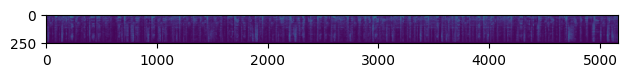

In [30]:
plt.imshow(gen_spec)
plt.tight_layout()
plt.show()

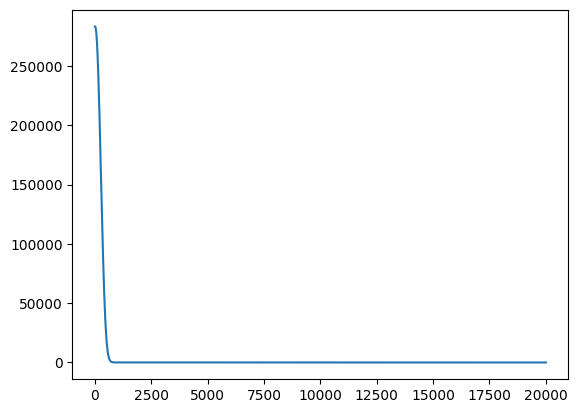

In [31]:
plt.plot(losses)
plt.show()